# COM MSD analysis: LiPF6 in DMC (0.75 M)

This notebook imports trajectories of center of mass (COM) of different species in an electrolyte system (`importTraj()`), calculates their self and cross mean squared displacements (`crossMSD()`), and analyzes the slope of the data to extract Onsager mobility matrix.

The mobility matrices are further used to calculate ionic conductivity and transference numbers.

## Functions

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Function to import trajectories of COM:

In [2]:
def importTraj(filename):
    data = np.loadtxt(os.getcwd() + '/posCOM' + filename + '.xvg', skiprows=26)
    return data[:,1:]

Function to get self or cross diffusion time series between two COM trajectories (pos1 and pos2) up to a time delay of $f^{th}$ fraction of trajectoties:

In [3]:
def crossMSD(pos1,pos2,f):
    msd=np.array([0])
    for i in range(1,int(len(pos1)/f)):
        dpos1 = pos1[i:]-pos1[:-i]
        dpos2 = pos2[i:]-pos2[:-i]
        dpos12 = np.multiply(dpos1,dpos2)
        msd = np.append(msd, np.mean(dpos12[:,0]+dpos12[:,1]+dpos12[:,2]))
    return msd

Function to extract slope from data [x, y] with a zero y intercept:

In [4]:
def slope(x,y):
    xCol = x[:,np.newaxis] #converting to column
    m, _, _, _ = np.linalg.lstsq(xCol, y, rcond=-1) 
    return m

## Trajectory 0

This is the analysis for the complete 720 ns simulation. Each of trajectories 1 through 6 is one-sixth of trajectory 0. 

### System

In [5]:
species = ['LI', 'PFF', 'DMC']
l = 8.11567 # length of box (nm)
V = l**3 # volume of box (nm^3)
T = 300 # temperatrue (K)
kB = 1.3806504e-23 # Boltzmann constant (SI units)

Defining electric field force vector:

In [6]:
ec = 1.602e-19;
nIon = 240;
EF = 6.25e7;
F = ((nIon*ec*EF)/V)*6.02214179e11* np.array([1, -1, 0]);

Importing COM trajectories:

In [7]:
pos = [importTraj(filename) for filename in species]

Calculating cross MSD time series matrix:

In [8]:
msd = [[crossMSD(pos[i],pos[j],10) for i in range(3)] for j in range(3)]

Fitting lines to msd time series:

In [9]:
t = np.arange(len(msd[0][0]))/10
# time in ns, depends on how frequently positions are recorded in the trajectory (here, every every 0.1 ns)

m = np.zeros((3,3)) # initializing slope matrix
for i in range(3):
    for j in range(3):
        m[i][j] = slope(t, msd[i][j])[0]

Calculating $M_{ij}$:

In [10]:
Mij = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        Mij[i][j] = (m[i][j]*V)/(6*kB*T*6.02214179)*10**(-20)

Calculating velocity of speice under electric field:

In [11]:
v = np.matmul(Mij,F)

In [12]:
sigma = (ec*nIon*(v[0] - v[1]))/(V*EF)*10**28
trans = v[0]/(v[0] - v[1])

### Results

In [13]:
new_species = ['$Li^+$','$PF_6^-$','$DMC$']

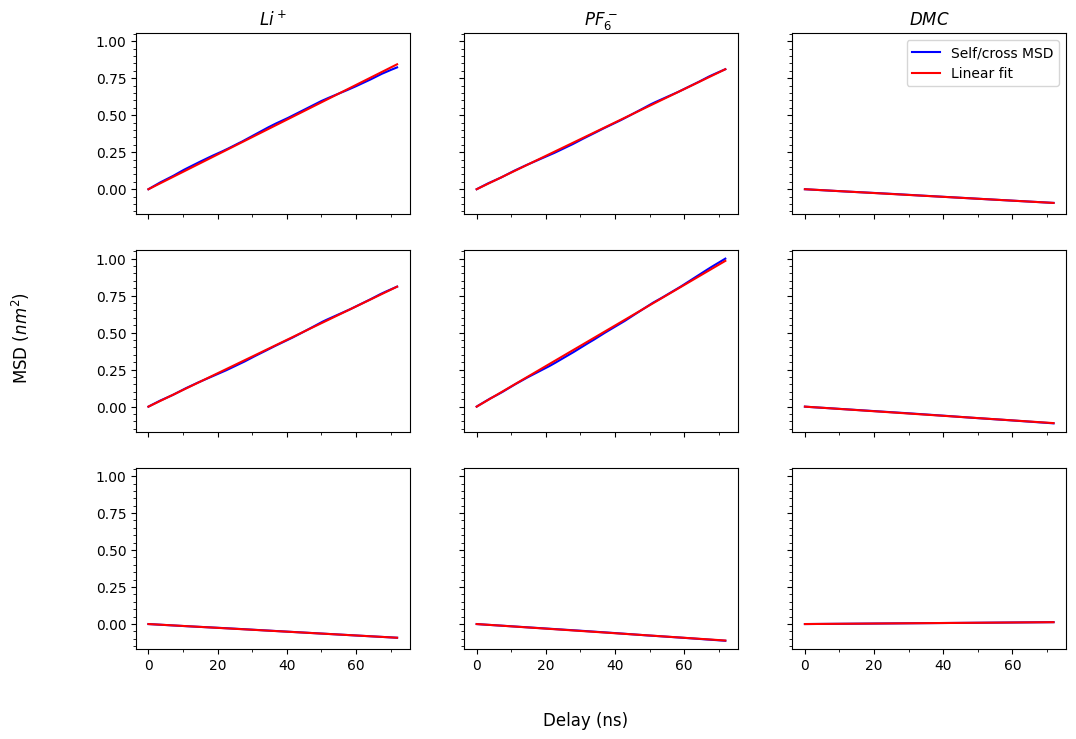

In [14]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in range(3):
    for j in range(3):
        if i == 0:
            axs[i][j].set_title(new_species[j]);
        axs[i][j].plot(t, msd[i][j], color='blue');
        axs[i][j].plot(t, t*m[i][j], color='red')
fig.supxlabel('Delay (ns)');
fig.supylabel('MSD ($nm^2$)');
axs[2][2].xaxis.set_minor_locator(MultipleLocator(10))
axs[2][2].yaxis.set_minor_locator(MultipleLocator(0.05))
for ax in fig.get_axes():
    ax.label_outer()
plt.legend(['Self/cross MSD', 'Linear fit'], bbox_to_anchor =(1.00, 3.40))
plt.savefig('diffusion.pdf')

In [15]:
np.set_printoptions(formatter={'float_kind':"{:.2f}".format})

In [16]:
print(10*Mij) #OMM ((nm^5 mol)/(10 ns kJ))

[[4.19 4.03 -0.46]
 [4.03 4.89 -0.55]
 [-0.46 -0.55 0.06]]


In [17]:
conductivity = []
print('{:.2f}'.format(sigma)) #conductivity (mS/cm)
conductivity.append(sigma)

transference = []
print('{:.2f}'.format(trans)) #transference number
transference.append(trans)

3.22
0.16


## Trajectory 1

### System

Calculating cross MSD time series matrix:

In [18]:
msd = [[crossMSD(pos[i][0:1200],pos[j][0:1200],10) for i in range(3)] for j in range(3)]

Fitting lines to msd time series:

In [19]:
t = np.arange(len(msd[0][0]))/10
# time in ns, depends on how frequently positions are recorded in the trajectory (here, every every 1/10 ns)

m = np.zeros((3,3)) # initializing slope matrix
for i in range(3):
    for j in range(3):
        m[i][j] = slope(t, msd[i][j])[0]

Calculating $M_{ij}$:

In [20]:
Mij = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        Mij[i][j] = (m[i][j]*V)/(6*kB*T*6.02214179)*10**(-20)

Calculating velocity of speice under electric field:

In [21]:
v = np.matmul(Mij,F)

In [22]:
sigma = (ec*nIon*(v[0] - v[1]))/(V*EF)*10**28
trans = v[0]/(v[0] - v[1])

### Results

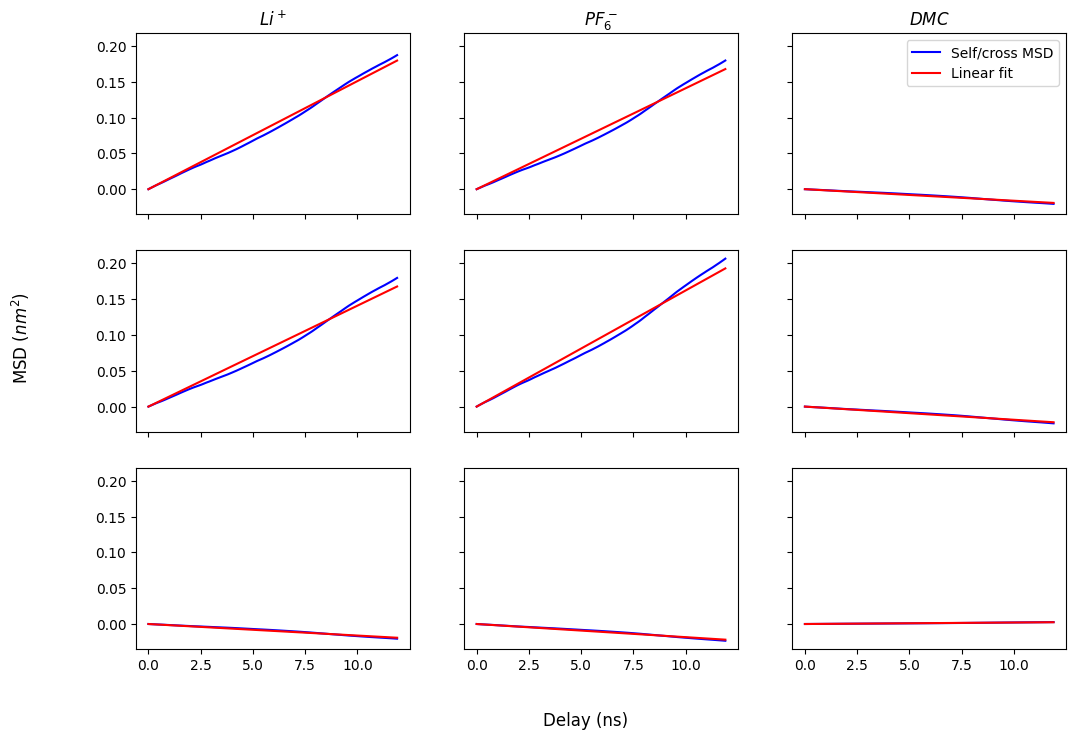

In [23]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in range(3):
    for j in range(3):
        if i == 0:
            axs[i][j].set_title(new_species[j]);
        axs[i][j].plot(t, msd[i][j], color='blue');
        axs[i][j].plot(t, t*m[i][j], color='red')
fig.supxlabel('Delay (ns)');
fig.supylabel('MSD ($nm^2$)');
axs[2][2].xaxis.set_minor_locator(MultipleLocator(10))
axs[2][2].yaxis.set_minor_locator(MultipleLocator(0.05))
for ax in fig.get_axes():
    ax.label_outer()
plt.legend(['Self/cross MSD', 'Linear fit'], bbox_to_anchor =(1.00, 3.40))

In [24]:
np.set_printoptions(formatter={'float_kind':"{:.2f}".format})

In [25]:
print(10*Mij) #OMM ((nm^5 mol)/(10 ns kJ))

[[5.39 5.03 -0.57]
 [5.03 5.79 -0.66]
 [-0.57 -0.66 0.07]]


In [26]:
print('{:.2f}'.format(sigma)) #conductivity (mS/cm)
conductivity.append(sigma)

print('{:.2f}'.format(trans)) #transference number
transference.append(trans)

3.47
0.32


## Trajectory 2

### System

Calculating cross MSD time series matrix:

In [27]:
msd = [[crossMSD(pos[i][1200:2400],pos[j][1200:2400],10) for i in range(3)] for j in range(3)]

Fitting lines to msd time series:

In [28]:
t = np.arange(len(msd[0][0]))/10
# time in ns, depends on how frequently positions are recorded in the trajectory (here, every every 1/10 ns)

m = np.zeros((3,3)) # initializing slope matrix
for i in range(3):
    for j in range(3):
        m[i][j] = slope(t, msd[i][j])[0]

Calculating $M_{ij}$:

In [29]:
Mij = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        Mij[i][j] = (m[i][j]*V)/(6*kB*T*6.02214179)*10**(-20)

Calculating velocity of speice under electric field:

In [30]:
v = np.matmul(Mij,F)

In [31]:
sigma = (ec*nIon*(v[0] - v[1]))/(V*EF)*10**28
trans = v[0]/(v[0] - v[1])

### Results

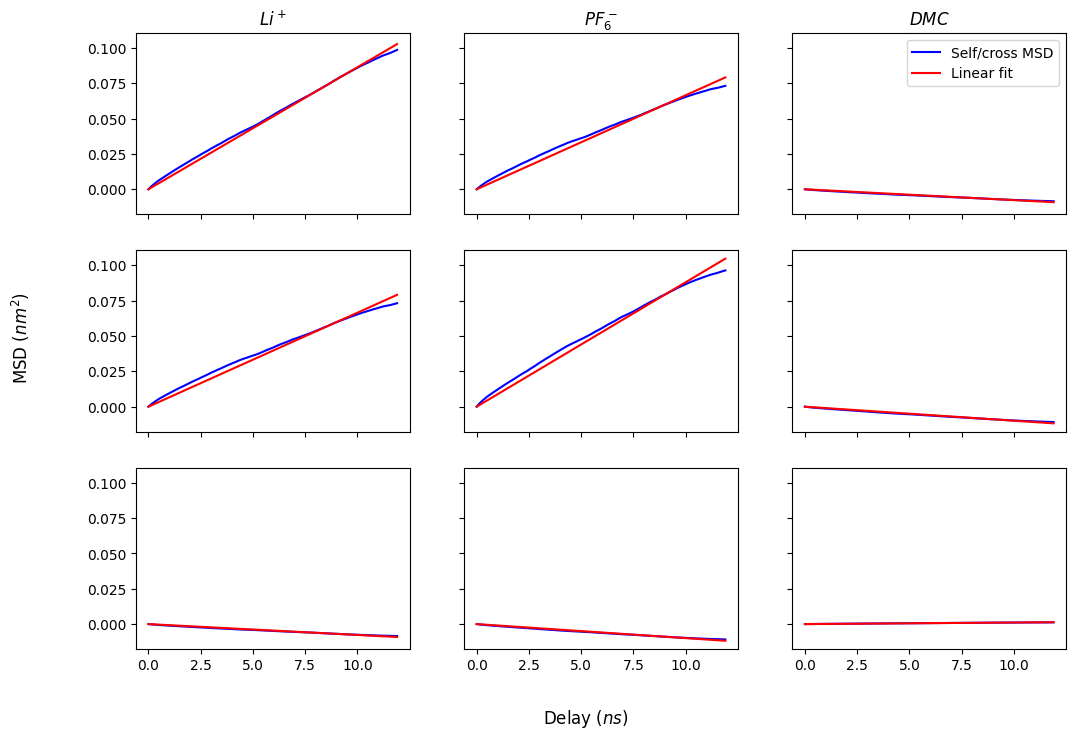

In [32]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
#fig.suptitle('Calculating OMM through diffusion')
for i in range(3):
    for j in range(3):
        if i == 0:
            axs[i][j].set_title(new_species[j]);
        axs[i][j].plot(t, msd[i][j], color='blue');
        axs[i][j].plot(t, t*m[i][j], color='red')
fig.supxlabel('Delay ($ns$)');
#fig.supylabel('MSD (nm^2)');
fig.supylabel('MSD ($nm^2$)');
axs[2][2].xaxis.set_minor_locator(MultipleLocator(10))
axs[2][2].yaxis.set_minor_locator(MultipleLocator(0.05))
for ax in fig.get_axes():
    ax.label_outer()
plt.legend(['Self/cross MSD', 'Linear fit'], bbox_to_anchor =(1.00, 3.40))

In [33]:
np.set_printoptions(formatter={'float_kind':"{:.2f}".format})

In [34]:
print(10*Mij) #OMM ((nm^5 mol)/(10 ns kJ))

[[3.08 2.37 -0.27]
 [2.37 3.14 -0.35]
 [-0.27 -0.35 0.04]]


In [35]:
print('{:.2f}'.format(sigma)) #conductivity (mS/cm)
conductivity.append(sigma)

print('{:.2f}'.format(trans)) #transference number
transference.append(trans)

4.60
0.48


## Trajectory 3

### System

Calculating cross MSD time series matrix:

In [36]:
msd = [[crossMSD(pos[i][2400:3600],pos[j][2400:3600],10) for i in range(3)] for j in range(3)]

Fitting lines to msd time series:

In [37]:
t = np.arange(len(msd[0][0]))/10
# time in ns, depends on how frequently positions are recorded in the trajectory (here, every every 1/100 ns)

m = np.zeros((3,3)) # initializing slope matrix
for i in range(3):
    for j in range(3):
        m[i][j] = slope(t, msd[i][j])[0]

Calculating $M_{ij}$:

In [38]:
Mij = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        Mij[i][j] = (m[i][j]*V)/(6*kB*T*6.02214179)*10**(-20)

Calculating velocity of speice under electric field:

In [39]:
v = np.matmul(Mij,F)

In [40]:
sigma = (ec*nIon*(v[0] - v[1]))/(V*EF)*10**28
trans = v[0]/(v[0] - v[1])

### Results

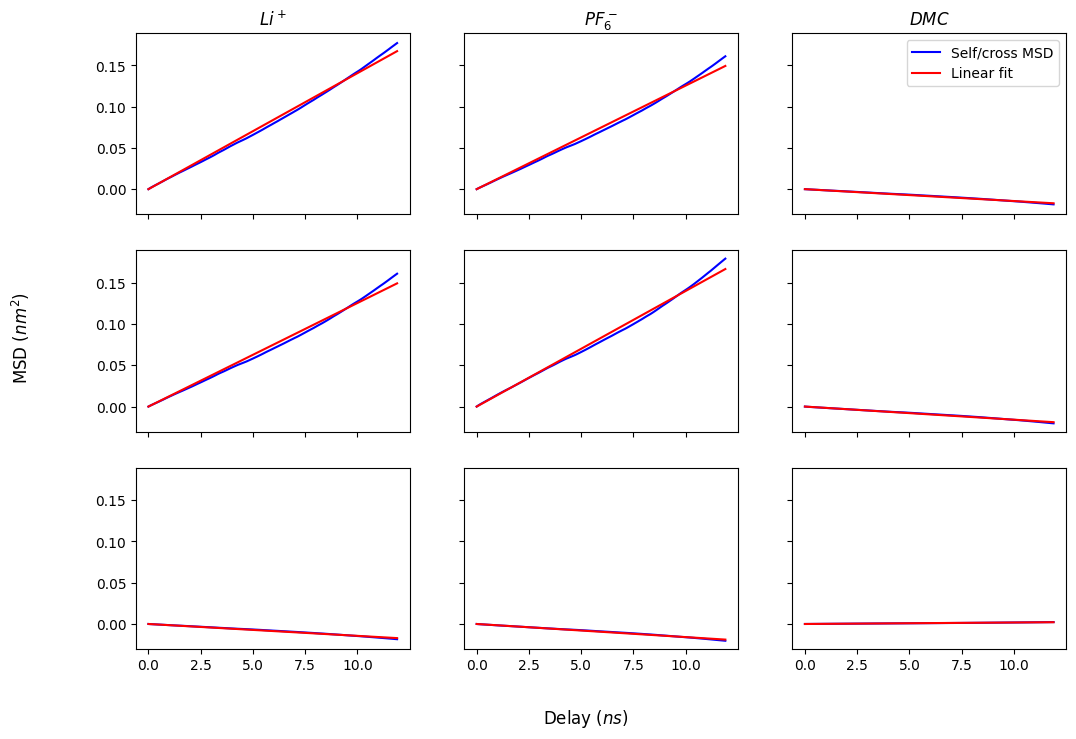

In [41]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in range(3):
    for j in range(3):
        if i == 0:
            axs[i][j].set_title(new_species[j]);
        axs[i][j].plot(t, msd[i][j], color='blue');
        axs[i][j].plot(t, t*m[i][j], color='red')
fig.supxlabel('Delay ($ns$)');
fig.supylabel('MSD ($nm^2$)');
axs[2][2].xaxis.set_minor_locator(MultipleLocator(10))
axs[2][2].yaxis.set_minor_locator(MultipleLocator(0.05))
for ax in fig.get_axes():
    ax.label_outer()
plt.legend(['Self/cross MSD', 'Linear fit'], bbox_to_anchor =(1.00, 3.40))

In [42]:
np.set_printoptions(formatter={'float_kind':"{:.2f}".format})

In [43]:
print(10*Mij) #OMM ((nm^5 mol)/(10 ns kJ))

[[5.02 4.48 -0.51]
 [4.48 5.00 -0.57]
 [-0.51 -0.57 0.06]]


In [44]:
print('{:.2f}'.format(sigma)) #conductivity (mS/cm)
conductivity.append(sigma)

print('{:.2f}'.format(trans)) #transference number
transference.append(trans)

3.30
0.51


## Trajectory 4

### System

Calculating cross MSD time series matrix:

In [45]:
msd = [[crossMSD(pos[i][3600:4800],pos[j][3600:4800],10) for i in range(3)] for j in range(3)]

Fitting lines to msd time series:

In [46]:
t = np.arange(len(msd[0][0]))/10
# time in ns, depends on how frequently positions are recorded in the trajectory (here, every every 1/100 ns)

m = np.zeros((3,3)) # initializing slope matrix
for i in range(3):
    for j in range(3):
        m[i][j] = slope(t, msd[i][j])[0]

Calculating $M_{ij}$:

In [47]:
Mij = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        Mij[i][j] = (m[i][j]*V)/(6*kB*T*6.02214179)*10**(-20)

Calculating velocity of speice under electric field:

In [48]:
v = np.matmul(Mij,F)

In [49]:
sigma = (ec*nIon*(v[0] - v[1]))/(V*EF)*10**28
trans = v[0]/(v[0] - v[1])

### Results

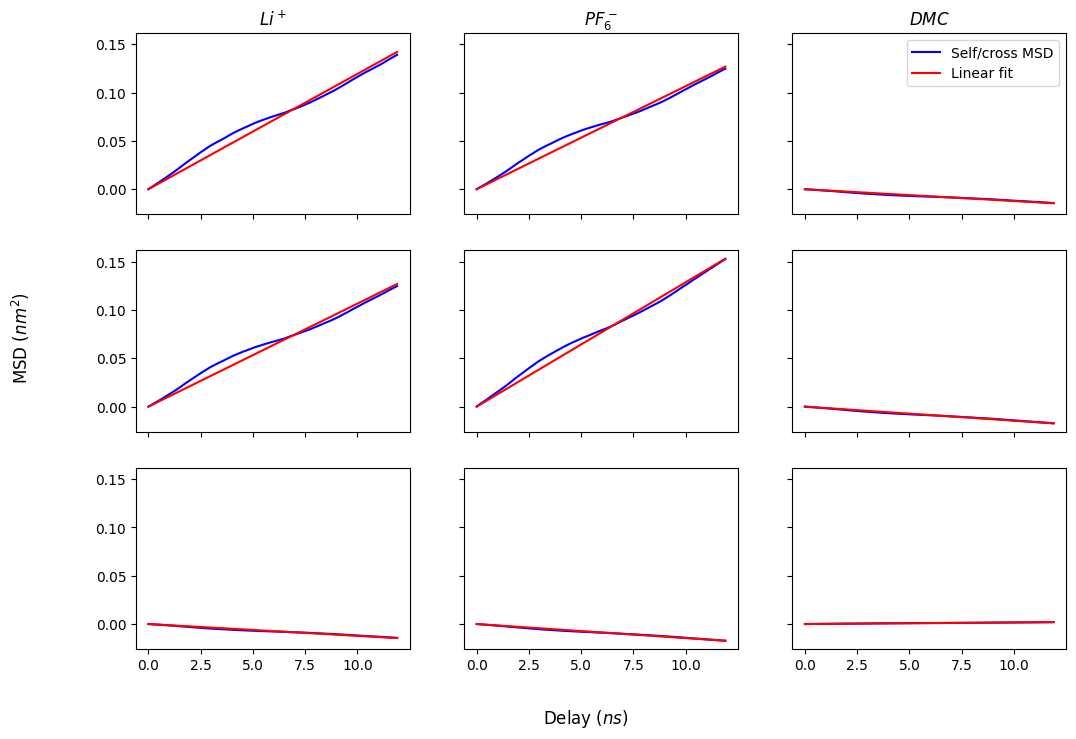

In [50]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in range(3):
    for j in range(3):
        if i == 0:
            axs[i][j].set_title(new_species[j]);
        axs[i][j].plot(t, msd[i][j], color='blue');
        axs[i][j].plot(t, t*m[i][j], color='red')
fig.supxlabel('Delay ($ns$)');
fig.supylabel('MSD ($nm^2$)');
axs[2][2].xaxis.set_minor_locator(MultipleLocator(10))
axs[2][2].yaxis.set_minor_locator(MultipleLocator(0.05))
for ax in fig.get_axes():
    ax.label_outer()
plt.legend(['Self/cross MSD', 'Linear fit'], bbox_to_anchor =(1.00, 3.40))

In [51]:
np.set_printoptions(formatter={'float_kind':"{:.2f}".format})

In [52]:
print(10*Mij) #OMM ((nm^5 mol)/(10 ns kJ))

[[4.26 3.81 -0.44]
 [3.81 4.60 -0.52]
 [-0.44 -0.52 0.06]]


In [53]:
print('{:.2f}'.format(sigma)) #conductivity (mS/cm)
conductivity.append(sigma)

print('{:.2f}'.format(trans)) #transference number
transference.append(trans)

3.87
0.37


## Trajectory 5

### System

Calculating cross MSD time series matrix:

In [54]:
msd = [[crossMSD(pos[i][4800:6000],pos[j][4800:6000],10) for i in range(3)] for j in range(3)]

Fitting lines to msd time series:

In [55]:
t = np.arange(len(msd[0][0]))/10
# time in ns, depends on how frequently positions are recorded in the trajectory (here, every every 1/100 ns)

m = np.zeros((3,3)) # initializing slope matrix
for i in range(3):
    for j in range(3):
        m[i][j] = slope(t, msd[i][j])[0]

Calculating $M_{ij}$:

In [56]:
Mij = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        Mij[i][j] = (m[i][j]*V)/(6*kB*T*6.02214179)*10**(-20)

Calculating velocity of speice under electric field:

In [57]:
v = np.matmul(Mij,F)

In [58]:
sigma = (ec*nIon*(v[0] - v[1]))/(V*EF)*10**28
trans = v[0]/(v[0] - v[1])

### Results

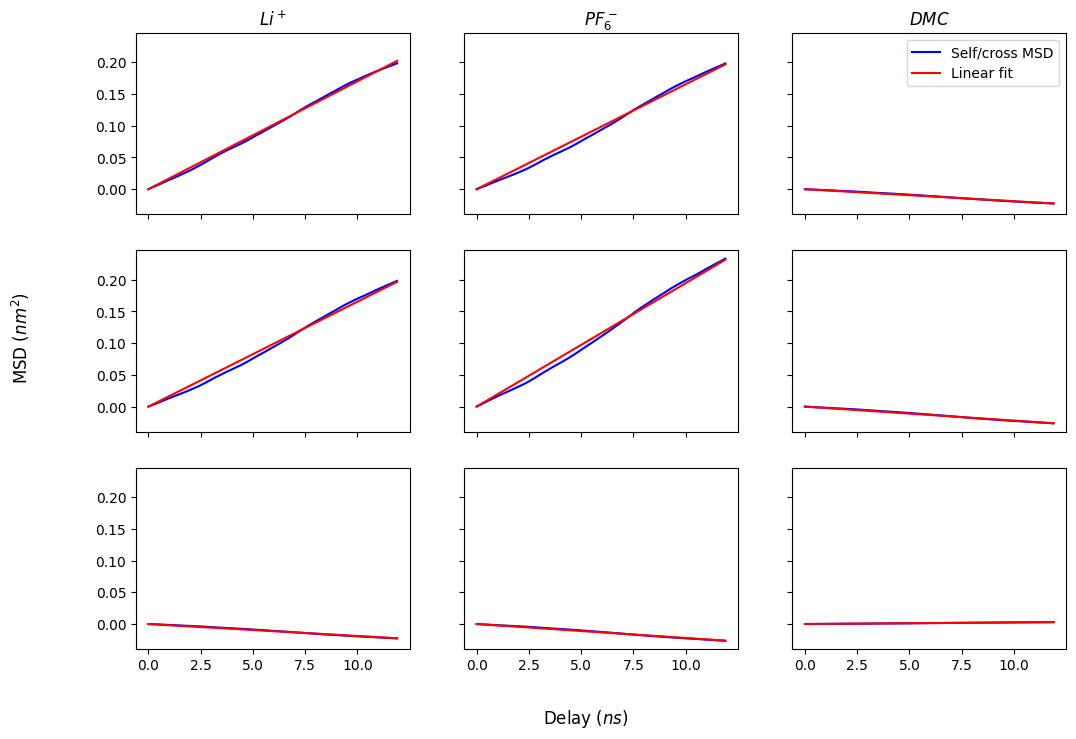

In [59]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in range(3):
    for j in range(3):
        if i == 0:
            axs[i][j].set_title(new_species[j]);
        axs[i][j].plot(t, msd[i][j], color='blue');
        axs[i][j].plot(t, t*m[i][j], color='red')
fig.supxlabel('Delay ($ns$)');
fig.supylabel('MSD ($nm^2$)');
axs[2][2].xaxis.set_minor_locator(MultipleLocator(10))
axs[2][2].yaxis.set_minor_locator(MultipleLocator(0.05))
for ax in fig.get_axes():
    ax.label_outer()
plt.legend(['Self/cross MSD', 'Linear fit'], bbox_to_anchor =(1.00, 3.40))

In [60]:
np.set_printoptions(formatter={'float_kind':"{:.2f}".format})

In [61]:
print(10*Mij) #OMM ((nm^5 mol)/(10 ns kJ))

[[6.07 5.90 -0.67]
 [5.90 6.95 -0.79]
 [-0.67 -0.79 0.09]]


In [62]:
print('{:.2f}'.format(sigma)) #conductivity (mS/cm)
conductivity.append(sigma)

print('{:.2f}'.format(trans)) #transference number
transference.append(trans)

3.76
0.14


## Trajectory 6

### System

Calculating cross MSD time series matrix:

In [63]:
msd = [[crossMSD(pos[i][6000:7200],pos[j][6000:7200],10) for i in range(3)] for j in range(3)]

Fitting lines to msd time series:

In [64]:
t = np.arange(len(msd[0][0]))/10
# time in ns, depends on how frequently positions are recorded in the trajectory (here, every every 1/100 ns)

m = np.zeros((3,3)) # initializing slope matrix
for i in range(3):
    for j in range(3):
        m[i][j] = slope(t, msd[i][j])[0]

Calculating $M_{ij}$:

In [65]:
Mij = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        Mij[i][j] = (m[i][j]*V)/(6*kB*T*6.02214179)*10**(-20)

Calculating velocity of speice under electric field:

In [66]:
v = np.matmul(Mij,F)

In [67]:
sigma = (ec*nIon*(v[0] - v[1]))/(V*EF)*10**28
trans = v[0]/(v[0] - v[1])

### Results

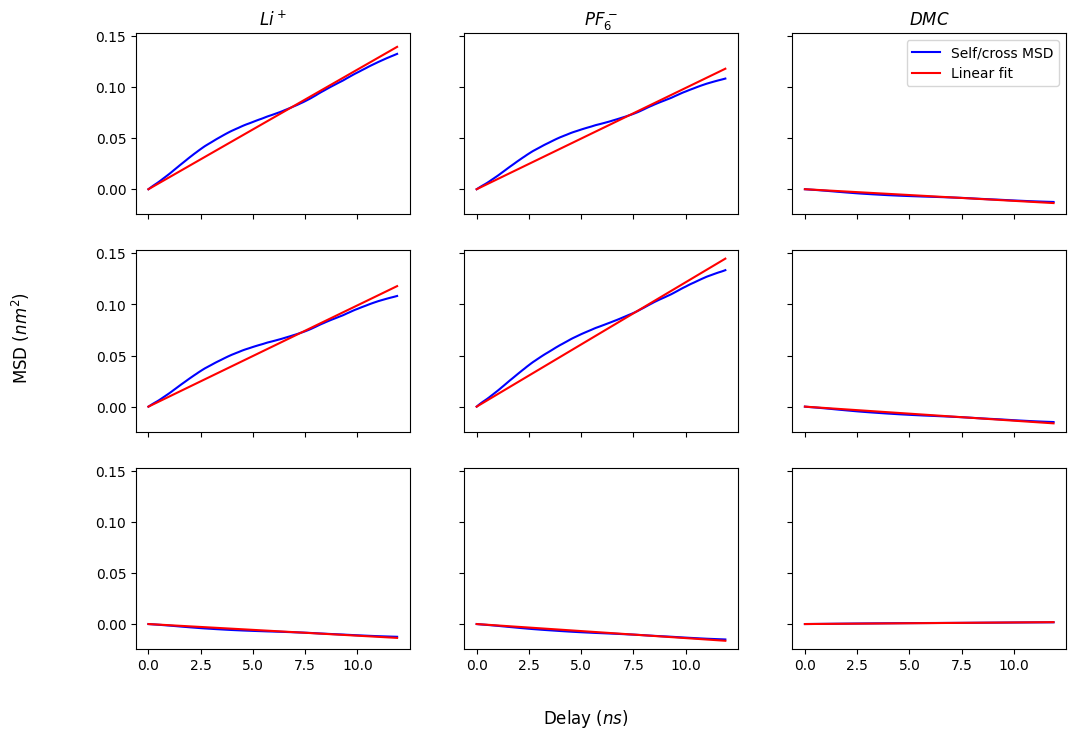

In [68]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in range(3):
    for j in range(3):
        if i == 0:
            axs[i][j].set_title(new_species[j]);
        axs[i][j].plot(t, msd[i][j], color='blue');
        axs[i][j].plot(t, t*m[i][j], color='red')
fig.supxlabel('Delay ($ns$)');
fig.supylabel('MSD ($nm^2$)');
axs[2][2].xaxis.set_minor_locator(MultipleLocator(10))
axs[2][2].yaxis.set_minor_locator(MultipleLocator(0.05))
for ax in fig.get_axes():
    ax.label_outer()
plt.legend(['Self/cross MSD', 'Linear fit'], bbox_to_anchor =(1.00, 3.40))

In [69]:
np.set_printoptions(formatter={'float_kind':"{:.2f}".format})

In [70]:
print(10*Mij) #OMM ((nm^5 mol)/(10 ns kJ))

[[4.18 3.54 -0.41]
 [3.54 4.34 -0.49]
 [-0.41 -0.49 0.06]]


In [71]:
print('{:.2f}'.format(sigma)) #conductivity (mS/cm)
conductivity.append(sigma)

print('{:.2f}'.format(trans)) #transference number
transference.append(trans)

4.51
0.44


## Errors

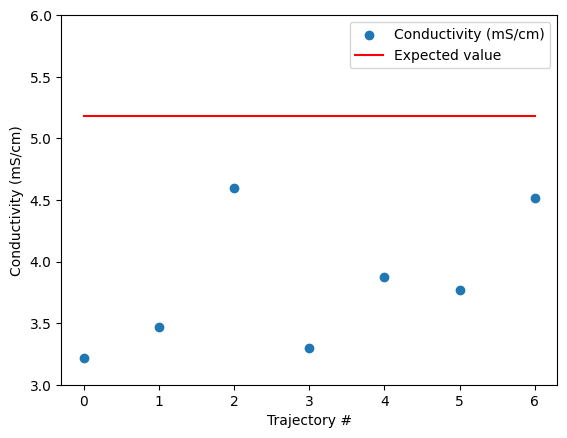

In [72]:
plt.scatter(range(7),conductivity);
plt.plot(range(7),[5.18 for i in range(7)], color='red');
plt.ylim(3, 6);
plt.xlabel('Trajectory #');
plt.ylabel('Conductivity (mS/cm)');
plt.legend(['Conductivity (mS/cm)', 'Expected value']);

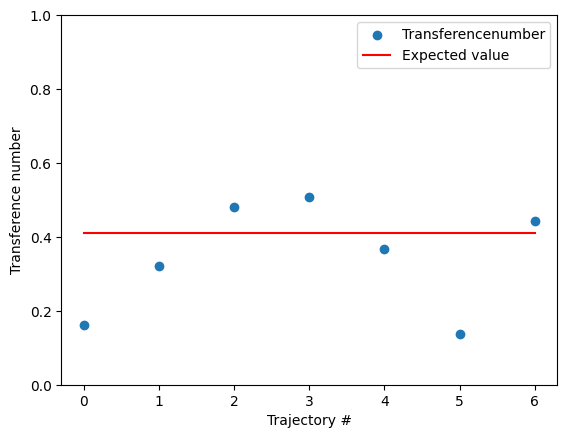

In [73]:
plt.scatter(range(7),transference);
plt.plot(range(7),[0.41 for i in range(7)], color='red')
plt.ylim(0, 1);
plt.xlabel('Trajectory #');
plt.ylabel('Transference number');
plt.legend(['Transferencenumber', 'Expected value']);

In [74]:
print(conductivity)
print(transference)

[3.2163255665775314, 3.470579953634486, 4.598735308631125, 3.300697169354448, 3.8732912352352598, 3.764931123504466, 4.511933352449588]
[0.16082902803840246, 0.3201199448198925, 0.4795116466422203, 0.5082839845836095, 0.36586515650153134, 0.13684275302147897, 0.4428593079824211]


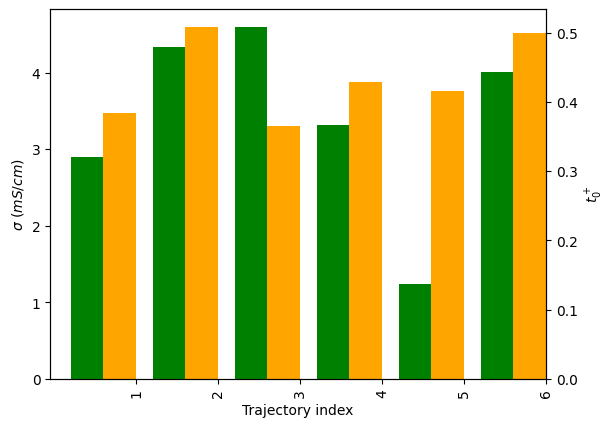

In [75]:
ar=np.array([conductivity,transference]).T;

df = pd.DataFrame(ar,columns =['sigma','t'])

fig = plt.figure()

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df.sigma[1:].plot(kind='bar', color='orange', ax=ax, width=width, position=1)
df.t[1:].plot(kind='bar', color='green', ax=ax2, width=width, position=2)

ax.set_ylabel('$\sigma$ $(mS/cm)$');
ax2.set_ylabel('$t_0^+$');
ax.set_xlabel('Trajectory index');
